### Numerical Methods Project 1
##### Ruozhen Gong

In [1]:
] add CSV

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


In [2]:
] add DataFrames

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


In [3]:
import Pkg; Pkg.add("ColorSchemes")

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


In [4]:
using CSV
using DataFrames

In [5]:
# read in data
alldata = CSV.read("data.csv", DataFrame);

In [6]:
size(alldata)

(20, 6)

In [7]:
# after checking the size of the data, modify it
data = alldata[5:end, :];

In [8]:
size(data)

(16, 6)

In [9]:
data.x

16-element Vector{Int64}:
 203
  58
 210
 202
 198
 158
 165
 201
 157
 131
 166
 160
 186
 125
 218
 146

In [10]:
# to make plots
using WGLMakie
using CairoMakie
using ColorSchemes

### Visualize the data and eyeball a linear fit

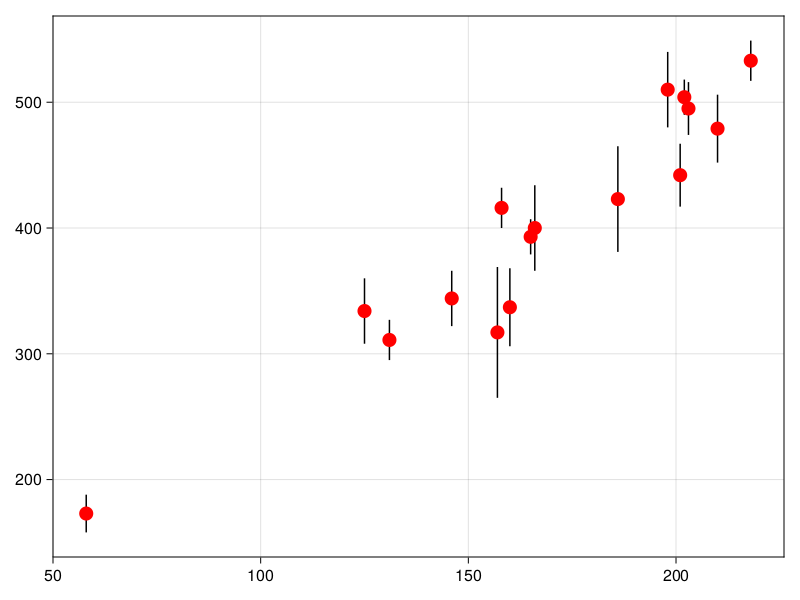

In [11]:
f = Figure()
Axis(f[1, 1])
errorbars!(data.x, data.y, data.sigma_y)
scatter!(data.x, data.y, markersize=20, color=:red) # specify things we want to display on this plot
f

In [12]:
# by observing the distribution of data points, guess two parameters for the linear fit
b_eye = 50.
m_eye = 2.
xx = LinRange(50, 250, 20)

20-element LinRange{Float64, Int64}:
 50.0,60.5263,71.0526,81.5789,92.1053,…,207.895,218.421,228.947,239.474,250.0

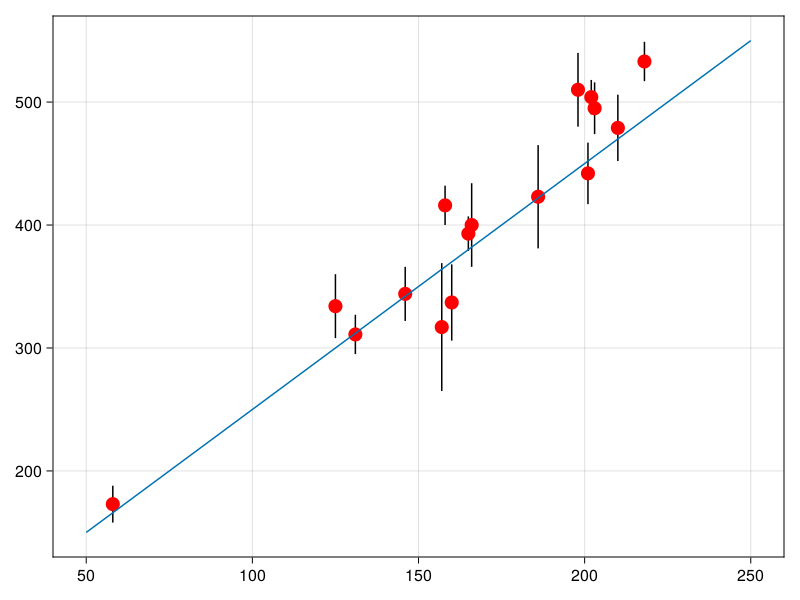

In [13]:
f = Figure()
Axis(f[1, 1])
errorbars!(data.x, data.y, data.sigma_y)
scatter!(data.x, data.y, markersize=20, color=:red)

yy_eye = xx .* m_eye .+ b_eye
lines!(xx, yy_eye)

f

### Optimizing some objective function
It can be solved as a linear algebra problem (solve a matrix solution using the least squares technique), but instead we treat it as an optimization of the linear fit. Optimize the likelihood of drawing the dataset given the model, using the Julia package Optim. Assume the data points are drawn from a Gaussian distribution around the model. (The linear algebra solution also assumes Gaussian.)\
Optimizer finds the m and b on the mb-plane that optimize some function.

In [14]:
] add Optim

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


In [15]:
using Optim

In [16]:
## Example objective function: in this metric, the closer b is to 3.4 and m is to 17 the better

function objective(parameters) # the target function to be optimized, to be passed on to the optimizer
    b = parameters[1] # some parameters
    m = parameters[2]
    @show b, m # prints values when this function is called.
    return abs(b - 3.4) + abs(m - 17) # returns a numerical value, which indicates how good the parameters are
end

objective (generic function with 1 method)

In [17]:
## Example 2: optimize the absolute value between the data point and predicted value
## This optimization considers all points equally, not considering the size of uncertainty of each point. To be more precise, one wants to consider the points with smaller uncertainties more seriously.

function objective_2(parameters)
    b = parameters[1]
    m = parameters[2]

    y_pred = b .+ m .* data.x
    
    return sum(abs.(data.y .- y_pred))
end

objective_2 (generic function with 1 method)

In [18]:
starting_params = [b_eye, m_eye]
result = optimize(objective_2, starting_params) # optimizer function takes the objective function and some starting parameters, pokes around in the parameter space to find the gradient descent to the optimal values
b_abs, m_abs = Optim.minimizer(result)

2-element Vector{Float64}:
 53.74766339105346
  2.056074767629348

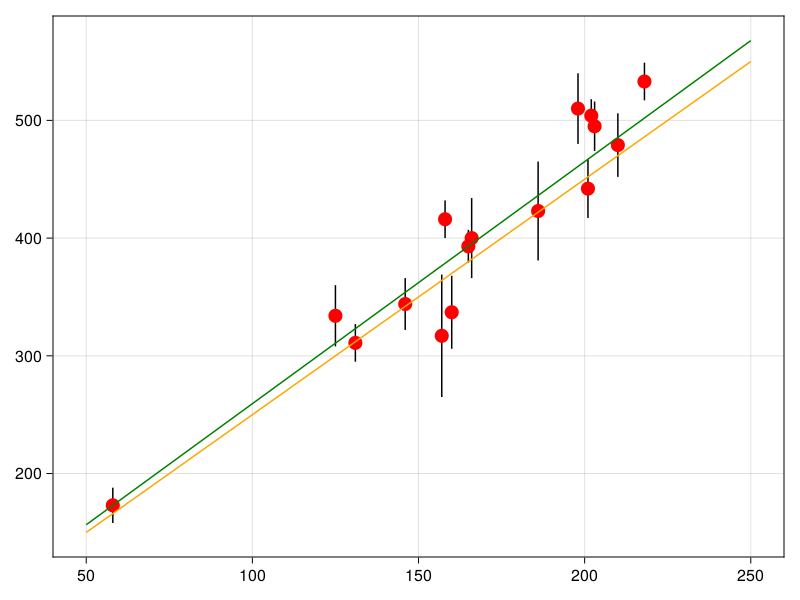

In [19]:
## Plot to compare the eyeballed linear fit and the result of optimizing the absolute distance between data and model
f = Figure()
Axis(f[1, 1])
errorbars!(data.x, data.y, data.sigma_y)
scatter!(data.x, data.y, markersize=20, color=:red)

yy_eye = xx .* m_eye .+ b_eye
lines!(xx, yy_eye, color=:orange)

yy_abs = xx .* m_abs .+ b_abs
lines!(xx, yy_abs, color=:green)

f

In [20]:
function objective_gauss(parameters, x, y, sigma)
    b = parameters[1]
    m = parameters[2]

    y_pred = b .+ m .* x
    
    return -sum( # since we want to maximize the likelihood with a minimizer, we minimize the negative of the function
        # we multiply the probability of finding each data point, implicitly assuming that the data are iid drawn
        -log.(sigma * sqrt(2 * π)) .-0.5 .* (y .- y_pred).^2 / sigma.^2) # go to the log space, otherwise the product of probabilities will be too small, everywhere 0
end

starting_params = [b_eye + 0., m_eye]
result = optimize(p -> objective_gauss(p, data.x, data.y, data.sigma_y), # anonymous function, passing in the global variables
                  starting_params)

b_gauss, m_gauss = Optim.minimizer(result)

2-element Vector{Float64}:
 28.84560565724924
  2.216646434317286

In [21]:
# optimize using poisson distribuiton

function objective_pois(parameters, x, y)
    b = parameters[1]
    m = parameters[2]

    y_pred = b .+ m .* x
    
    return -sum( # since we want to maximize the likelihood with a minimizer, we minimize the negative of the function
        # we multiply the probability of finding each data point, implicitly assuming that the data are iid drawn
        log.((y_pred.^y).*exp.(-y_pred)./factorial.(big.(y)))) # go to the log space, otherwise the product of probabilities will be too small, everywhere 0
end

starting_params = [b_eye + 0., m_eye]
result = optimize(p -> objective_pois(p, data.x, data.y), # anonymous function, passing in the global variables
                  starting_params)

b_pois, m_pois = Optim.minimizer(result)

2-element Vector{Float64}:
 50.0
  2.0

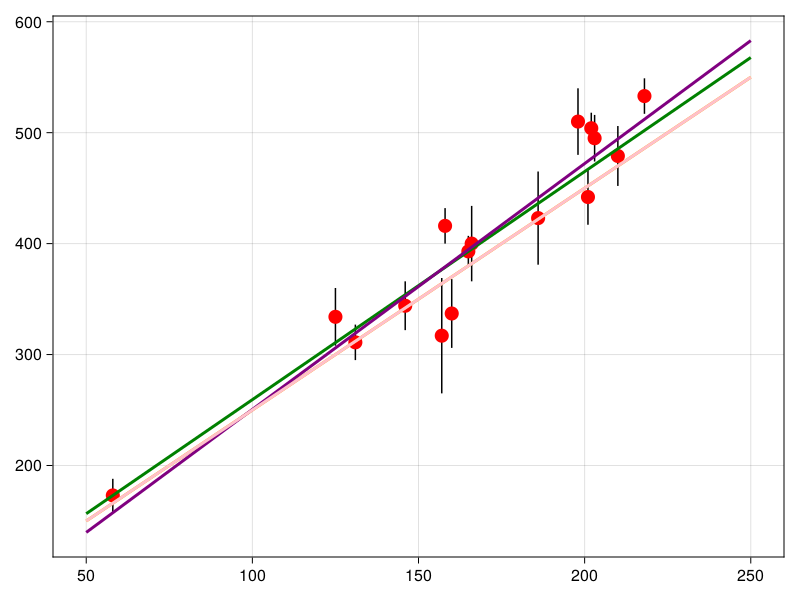

In [22]:
## We plot and compare three different linear fit

f = Figure()
Axis(f[1, 1])
errorbars!(data.x, data.y, data.sigma_y)
scatter!(data.x, data.y, markersize=20, color=:red)

yy_eye = xx .* m_eye .+ b_eye
lines!(xx, yy_eye, color=:orange, linewidth=3)

yy_abs = xx .* m_abs .+ b_abs
lines!(xx, yy_abs, color=:green, linewidth=3)

yy_gauss = xx .* m_gauss .+ b_gauss
lines!(xx, yy_gauss, color=:purple, linewidth=3)

yy_pois = xx .* m_pois .+ b_pois
lines!(xx, yy_pois, color=:pink, linewidth=3)

f

In [23]:
@show data.x;

data.x = [203, 58, 210, 202, 198, 158, 165, 201, 157, 131, 166, 160, 186, 125, 218, 146]


In [24]:
size(data, 1)

16

### The Jack-knife analysis: a resampling method to measure the variability of the data

In [25]:
ndata = size(data,1)

B_jack = zeros(ndata)
M_jack = zeros(ndata)

for i in 1:ndata # for each data point, create a copy where we delete that specific point, and do gaussian optimization, append the optimal parameters to the list of B_jack and M_jack
    
    xcopy = copy(data.x)
    deleteat!(xcopy, i)

    ycopy = copy(data.y)
    deleteat!(ycopy, i)

    scopy = copy(data.sigma_y)
    deleteat!(scopy, i)

    starting_params = [b_eye + 0., m_eye]
    result = optimize(p -> objective_gauss(p, xcopy, ycopy, scopy),
                      starting_params)
    @assert Optim.converged(result) # this will return an error if not true
    b_jack, m_jack = Optim.minimizer(result)
    
    B_jack[i] = b_jack
    M_jack[i] = m_jack 
end

In [26]:
@assert 2+2 == 4

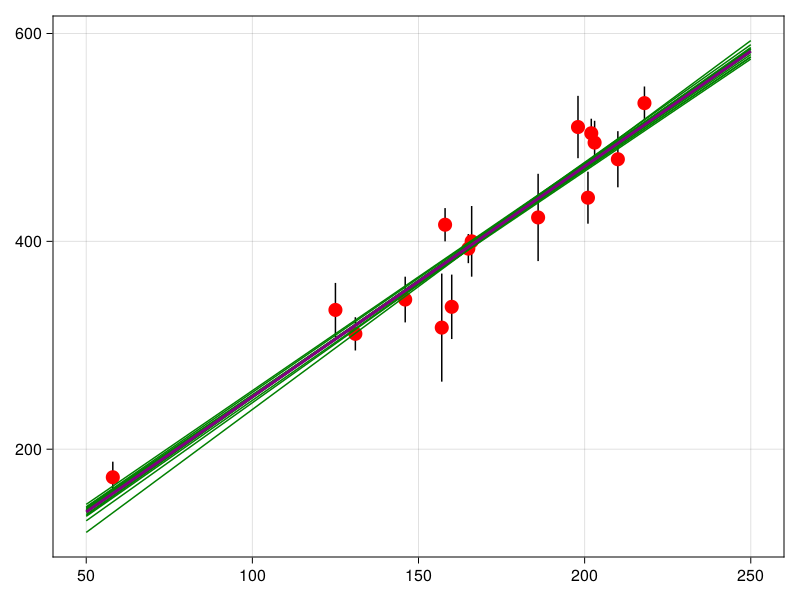

In [27]:
f = Figure()
Axis(f[1, 1])
errorbars!(data.x, data.y, data.sigma_y)
scatter!(data.x, data.y, markersize=20, color=:red)

# plot each linear fit in the collection
for i in 1:ndata
    yy_jack = xx .* M_jack[i] .+ B_jack[i]
    lines!(xx, yy_jack, color=:green)
end

# plot Gaussian on top
yy_gauss = xx .* m_gauss .+ b_gauss
lines!(xx, yy_gauss, color=:purple, linewidth=3)

f

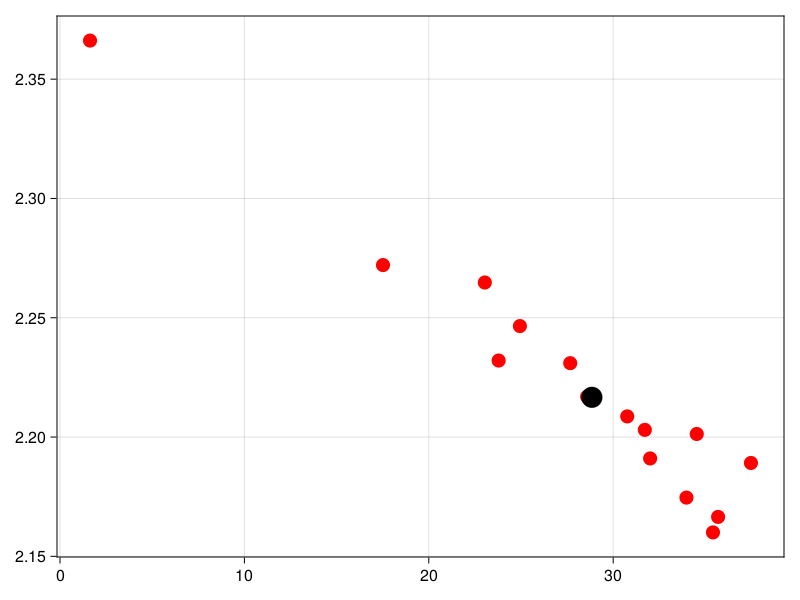

In [28]:
# plot B_jack and M_jack on mb-space
f = Figure()
Axis(f[1, 1])
scatter!(B_jack, M_jack, markersize=20, color=:red)

plot!([b_gauss], [m_gauss], markersize=30)

f

In [29]:
using Statistics

In [30]:
mean(B_jack), std(B_jack) .* sqrt((ndata - 1) / ndata)

(27.982644701170038, 8.58069162338665)

In [31]:
mean(M_jack), std(M_jack) .* sqrt((ndata - 1) / ndata)

(2.2212591046386256, 0.04881277590712103)

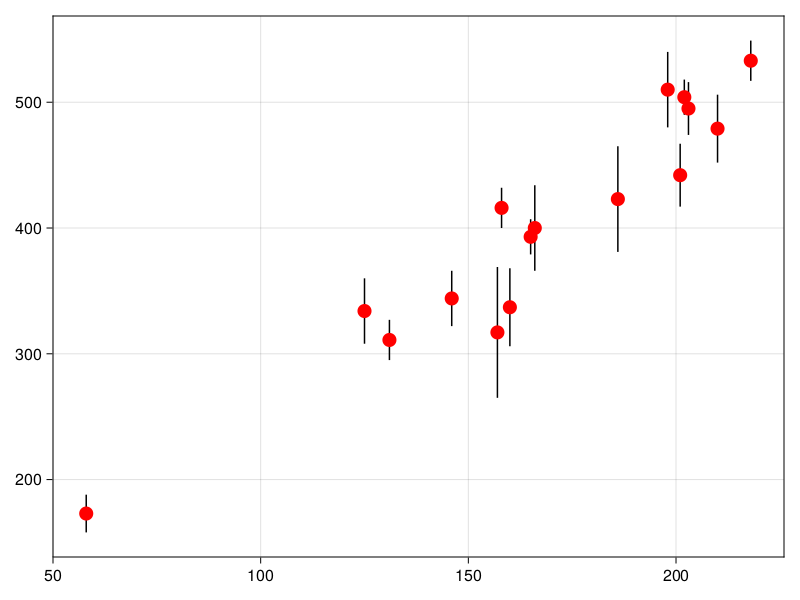

In [72]:
f = Figure()
Axis(f[1, 1])
errorbars!(data.x, data.y, data.sigma_y)
scatter!(data.x, data.y, markersize=20, color=:red)
f

In [73]:
starting_params = [b_eye + 0., m_eye]
result = optimize(p -> objective_gauss(p, data.x, data.y, data.sigma_y),
                  starting_params)
@assert Optim.converged(result)
b_bad, m_bad = Optim.minimizer(result)

2-element Vector{Float64}:
 28.84560565724924
  2.216646434317286

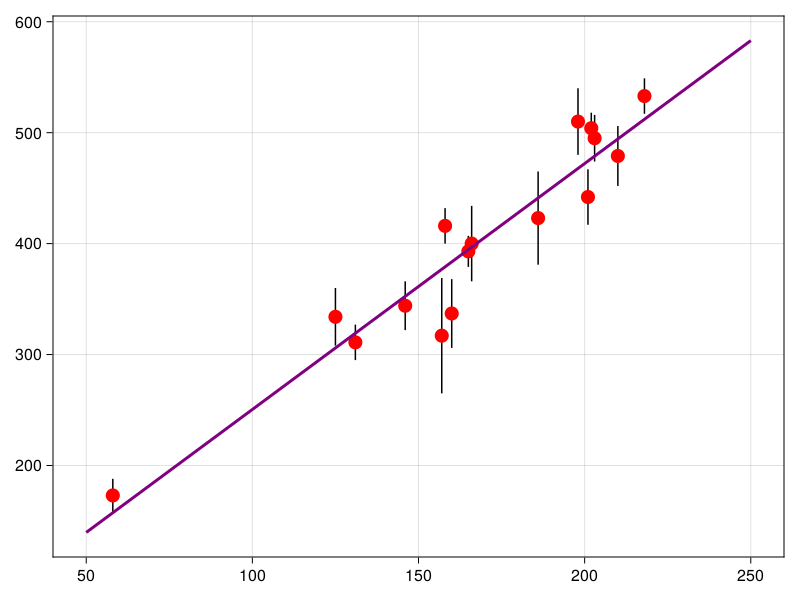

In [74]:
f = Figure()
Axis(f[1, 1])
errorbars!(data.x, data.y, data.sigma_y)
scatter!(data.x, data.y, markersize=20, color=:red)

yy_bad = xx .* m_bad .+ b_bad
lines!(xx, yy_bad, color=:purple, linewidth=3)

f

In [88]:
function objective_outliers(parameters, x, y, sigma)
    b = parameters[1]
    m = parameters[2]

    frac_bad = 0.01
    like_bad = frac_bad * (1. / 600.)

    y_pred = b .+ m .* x
    like_good = (1. - frac_bad) * 1 ./(sqrt(2*π) .* sigma) .* exp.(-0.5 * (y .- y_pred).^2 ./ sigma.^2)
    like = like_bad .+ like_good
    loglike = log.(like)

    return -sum(loglike)
end

objective_outliers (generic function with 1 method)

In [89]:
starting_params = [b_eye + 0., m_eye]
result = optimize(p -> objective_outliers(p, data.x, data.y, data.sigma_y),
                  starting_params)
@assert Optim.converged(result)
b_out, m_out = Optim.minimizer(result)

2-element Vector{Float64}:
 34.04506463817255
  2.2400013020506995

In [90]:
starting_params = [700 + 0., -0.5]
result = optimize(p -> objective_outliers(p, data.x, data.y, data.sigma_y),
                  starting_params)
@assert Optim.converged(result)
b_punk, m_punk = Optim.minimizer(result)

2-element Vector{Float64}:
 34.044185215740576
  2.2400060123364565

Use Gaussian optimizer to optimize speculated starting parameters: 

In [91]:
starting_params = [b_eye + 0., m_eye]
result = optimize(p -> objective_gauss(p, data.x, data.y, data.sigma_y),
                  starting_params)
@assert Optim.converged(result)
b_bad, m_bad = Optim.minimizer(result)

2-element Vector{Float64}:
 28.84560565724924
  2.216646434317286

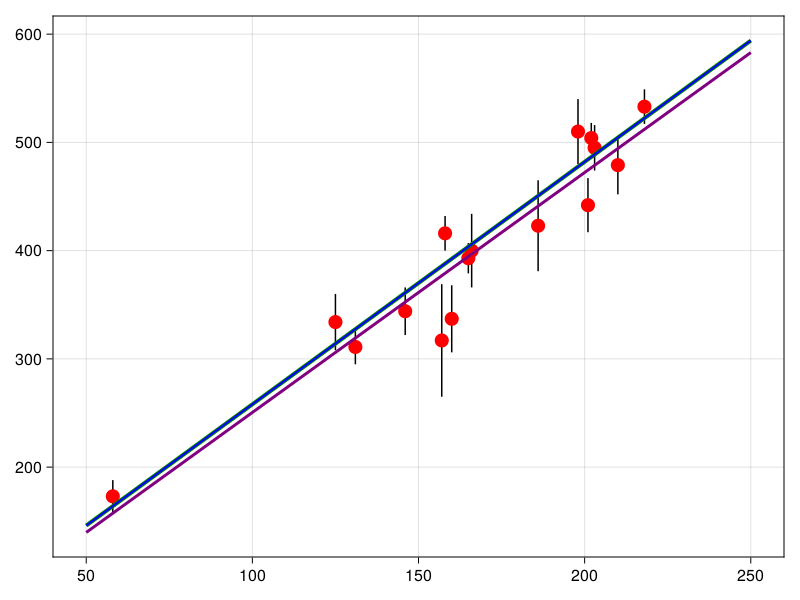

In [96]:
f = Figure()
Axis(f[1, 1])
errorbars!(data.x, data.y, data.sigma_y)
scatter!(data.x, data.y, markersize=20, color=:red)

yy_bad = xx .* m_bad .+ b_bad
lines!(xx, yy_bad, color=:purple, linewidth=3)

yy_out = xx .* m_out .+ b_out
lines!(xx, yy_out, color=:green, linewidth=4)

yy_punk = xx .* m_punk .+ b_punk
lines!(xx, yy_punk, color=:blue, linewidth=2)

f

Above are what we did in the tutorial. Below is the project. 

# Task 1: A higher-order fit
We did a linear fit (y_pred = b + m x).  Try extending the code to do a quadratic fit: y_pred = b + m x + q x^2. Does the fit improve?  Repeat the jack-knife analysis (and plot up the answers produced by each run of the jack-knife), and investigate the scatter in the "q" values.  Can you conclude anything about whether you need the "q" term for a good fit?

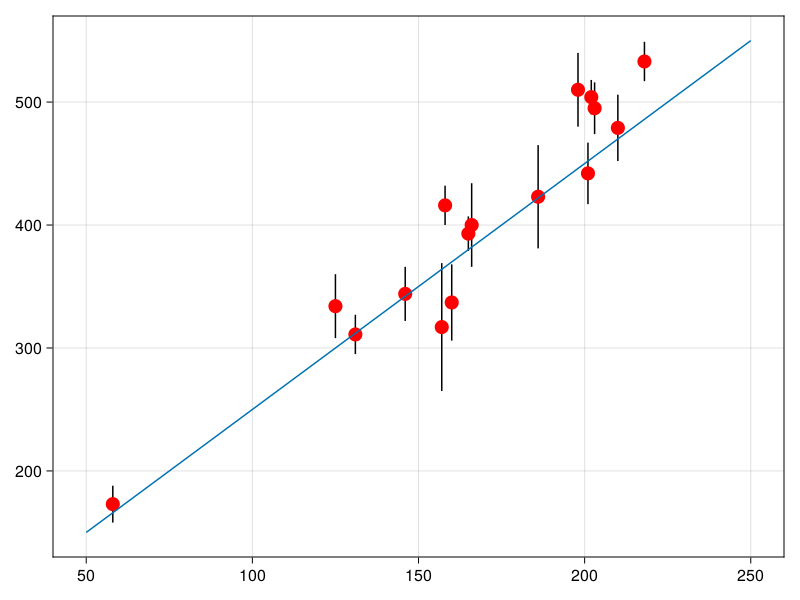

In [97]:
# eyeball a quadratic fit
quad_b_eye = 50.
quad_m_eye = 2.
quad_q_eye = 0.0001
xx = LinRange(50, 250, 20)

f = Figure()
Axis(f[1, 1])
errorbars!(data.x, data.y, data.sigma_y)
scatter!(data.x, data.y, markersize=20, color=:red)

quad_yy_eye = quad_q_eye .* xx.^2 + xx .* quad_m_eye .+ quad_b_eye
lines!(xx, yy_eye)

f

In [98]:
# this objective function maximizes the likelihood of the data points to appear in a gaussian distribution around the predicted model
function quad_objective_gauss(parameters, x, y, sigma)
    b = parameters[1]
    m = parameters[2]
    q = parameters[3]
    y_pred = b .+ m .* x .+ q .* x.^2
    
    return -sum(
        -log.(sigma * sqrt(2 * π)) .-0.5 .* (y .- y_pred).^2 / sigma.^2)
end


quad_objective_gauss (generic function with 1 method)

In [99]:
## parameters to be optimized: b, m, q
quad_starting_params = [quad_b_eye, quad_m_eye, quad_q_eye]
result = optimize(p -> quad_objective_gauss(p, data.x, data.y, data.sigma_y), quad_starting_params)
quad_b_gauss, quad_m_gauss, quad_q_gauss = Optim.minimizer(result)


3-element Vector{Float64}:
 101.51896911563242
   1.1121070205157777
   0.0037908789258497876

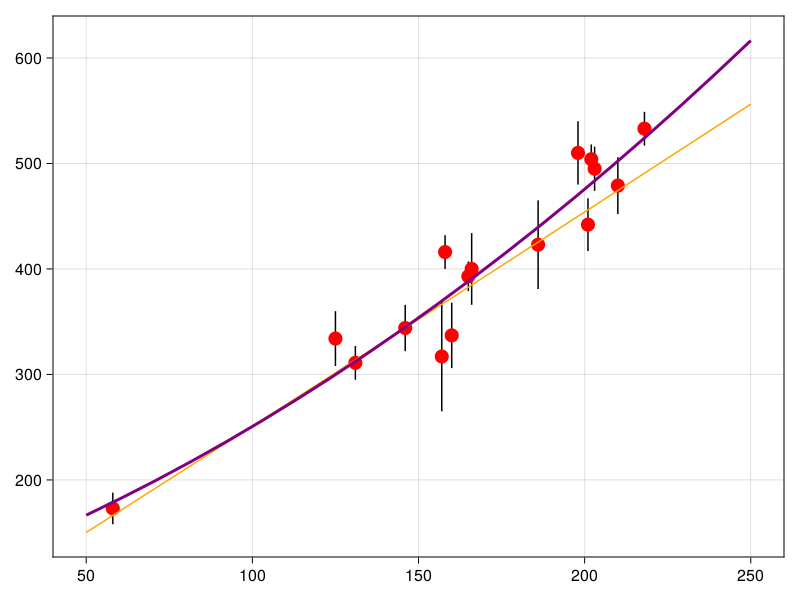

In [100]:
## plot the quadratic fit
f = Figure()
Axis(f[1, 1])
errorbars!(data.x, data.y, data.sigma_y)
scatter!(data.x, data.y, markersize=20, color=:red)

quad_yy_eye = xx .* quad_m_eye .+ quad_b_eye + quad_q_eye*xx.^2
lines!(xx, quad_yy_eye, color=:orange)


quad_yy_gauss = xx .* quad_m_gauss .+ quad_b_gauss + quad_q_gauss*xx.^2
lines!(xx, quad_yy_gauss, color=:purple, linewidth=3)

f

In [101]:
# Jackknife analysis

ndata = size(data,1)

quad_B_jack = zeros(ndata)
quad_M_jack = zeros(ndata)
quad_Q_jack = zeros(ndata)

for i in 1:ndata # for each data point, create a copy where we delete that specific point, and do gaussian optimization, append the optimal parameters to the list of B_jack and M_jack
    
    xcopy = copy(data.x)
    deleteat!(xcopy, i)

    ycopy = copy(data.y)
    deleteat!(ycopy, i)

    scopy = copy(data.sigma_y)
    deleteat!(scopy, i)

    starting_params = [quad_b_eye, quad_m_eye, quad_q_eye]
    result = optimize(p -> quad_objective_gauss(p, xcopy, ycopy, scopy),
                      starting_params)
    @assert Optim.converged(result) # this will return an error if not true
    quad_b_jack, quad_m_jack, quad_q_jack = Optim.minimizer(result)
    
    quad_B_jack[i] = quad_b_jack
    quad_M_jack[i] = quad_m_jack 
    quad_Q_jack[i] = quad_q_jack
end

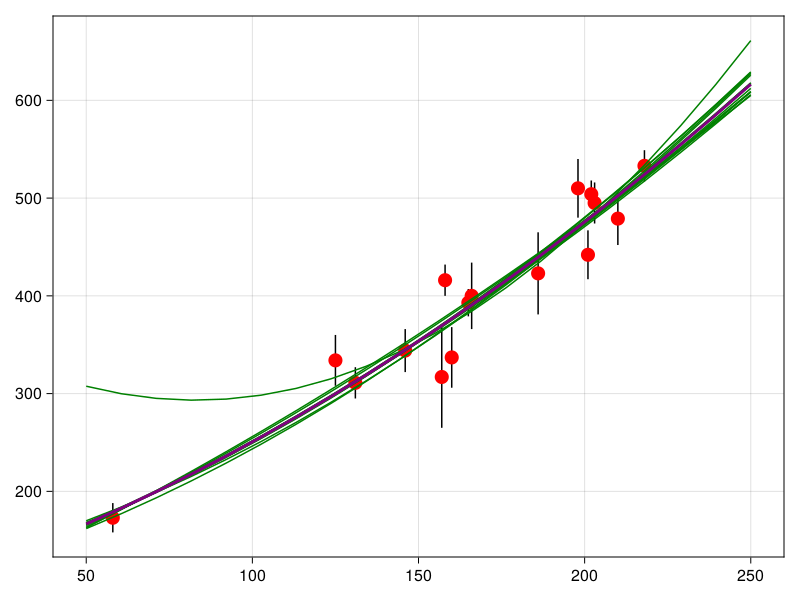

In [102]:
# plot the gaussian quadratic fit on top of the fit resulted from each run of the jack-knife

f = Figure()
Axis(f[1, 1])
errorbars!(data.x, data.y, data.sigma_y)
scatter!(data.x, data.y, markersize=20, color=:red)

# plot each linear fit in the collection
for i in 1:ndata
    quad_yy_jack = xx .* quad_M_jack[i] .+ quad_B_jack[i] + quad_Q_jack[i] .* xx.^2
    lines!(xx, quad_yy_jack, color=:green)
end

# plot Gaussian on top
quad_yy_gauss = xx .* quad_m_gauss .+ quad_b_gauss + quad_q_gauss*xx.^2
lines!(xx, quad_yy_gauss, color=:purple, linewidth=3)

f

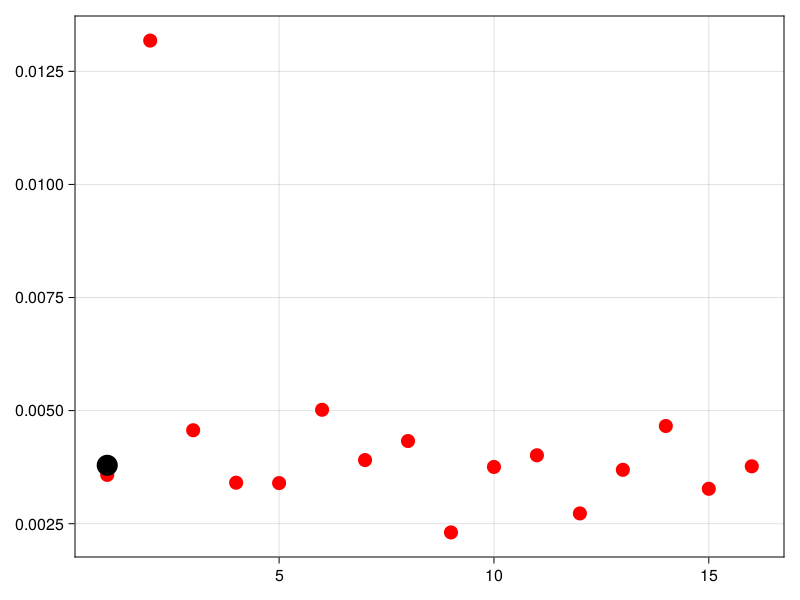

In [103]:
# plot the scatterplot of Q_jack on the parameter space, investigate the distribution of "q" values.

f = Figure()
Axis(f[1, 1])
scatter!(quad_Q_jack, markersize=20, color=:red)

plot!([quad_q_gauss], markersize=30)

f

In [104]:
# investigate the statistics of the q jacks: check mean and standard deviation

mean(quad_Q_jack), std(quad_Q_jack) .* sqrt((ndata - 1) / ndata)

(0.0043485759364351164, 0.002376203903131321)

Conclusion: The q values are all close to 0, so we don't need to include this as a parameter. 

# Task 2: Investigate the m,b plane

In class we plotted up our solutions in the m,b coordinate plane.  Here, I'd like you to investigate a bit more.  Try making a contour plots of the (Gaussian) objective function (in terms of m,b), but giving it only a single data point.  (I think you should find that there is a diagonal locus of m,b values that have a maximum log-likelihood (so minimum objective-function value), because those lines go right through that single data point.  Now try the same thing with a different data point.  (Plot both contours on the same plot.  Then also try plotting the contour for the two data points combined.)  Now try all data points.  

Now go back to the linear fit, and we only have two parameters m and b. 

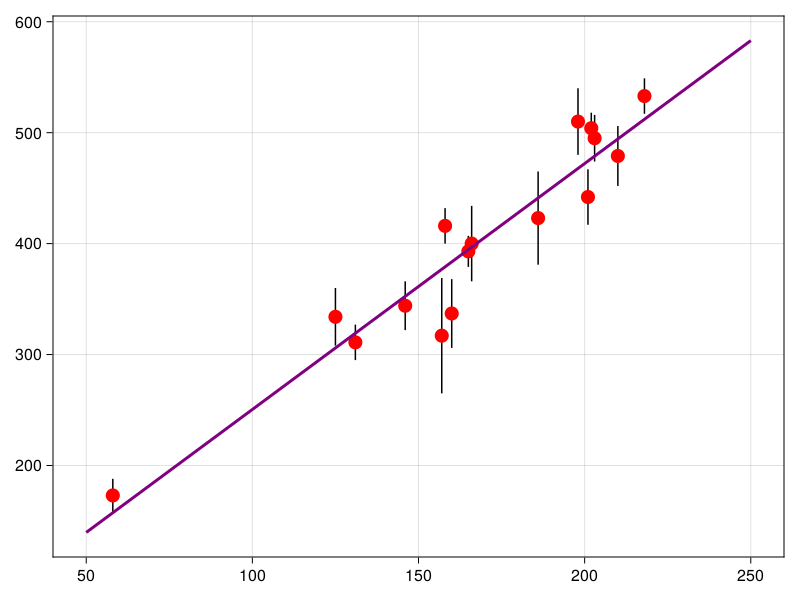

In [105]:
f = Figure()
Axis(f[1, 1])
errorbars!(data.x, data.y, data.sigma_y)
scatter!(data.x, data.y, markersize=20, color=:red)

yy_gauss = xx .* m_gauss .+ b_gauss
lines!(xx, yy_gauss, color=:purple, linewidth=3)
f

What are the contour plots? They indicate the likelihood of observing a data point $y_i$ given m and b. The probabilities are equal along the contour lines.
Below, we make a contour plot with just the first data point as I'm pulling out elements 1.

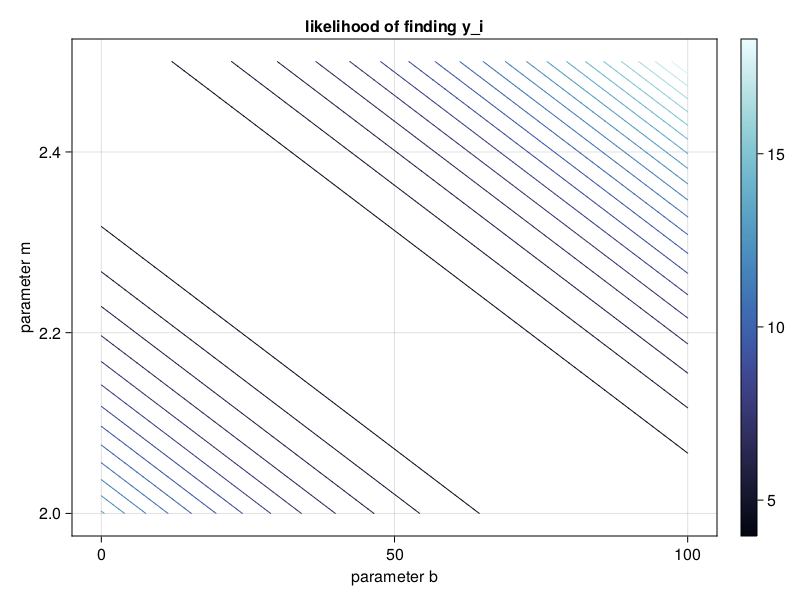

In [106]:
# Range of m,b values to plot
bvals = LinRange(0., 100., 100)
mvals = LinRange(2.0, 2.5, 100);
# Compute the objective function for each point in a grid
og1 = [objective_gauss([b,m], data.x[1], data.y[1], data.sigma_y[1])
      for b in bvals, m in mvals]
f = Figure()
Axis(f[1, 1],xlabel = "parameter b", ylabel = "parameter m", title = "likelihood of finding y_i")
contour1 = contour!(bvals, mvals, og1, levels=20, colormap = ColorSchemes.ice.colors )
Colorbar(f[1, 2],contour1)
f

Now look at point 2. 

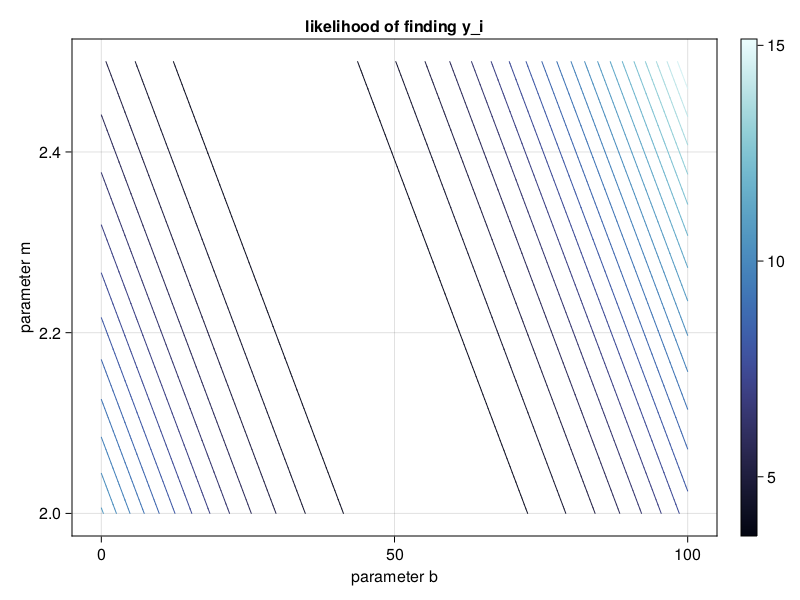

In [107]:
# Range of m,b values to plot
bvals = LinRange(0., 100., 100)
mvals = LinRange(2.0, 2.5, 100);
# Compute the objective function for each point in a grid
og2 = [objective_gauss([b,m], data.x[2], data.y[2], data.sigma_y[2])
      for b in bvals, m in mvals]
f = Figure()
Axis(f[1, 1],xlabel = "parameter b", ylabel = "parameter m", title = "likelihood of finding y_i")
contour2 = contour!(bvals, mvals, og2, levels=20, colormap = ColorSchemes.ice.colors )
Colorbar(f[1, 2],contour2)
f

Now put them in the same plot. 

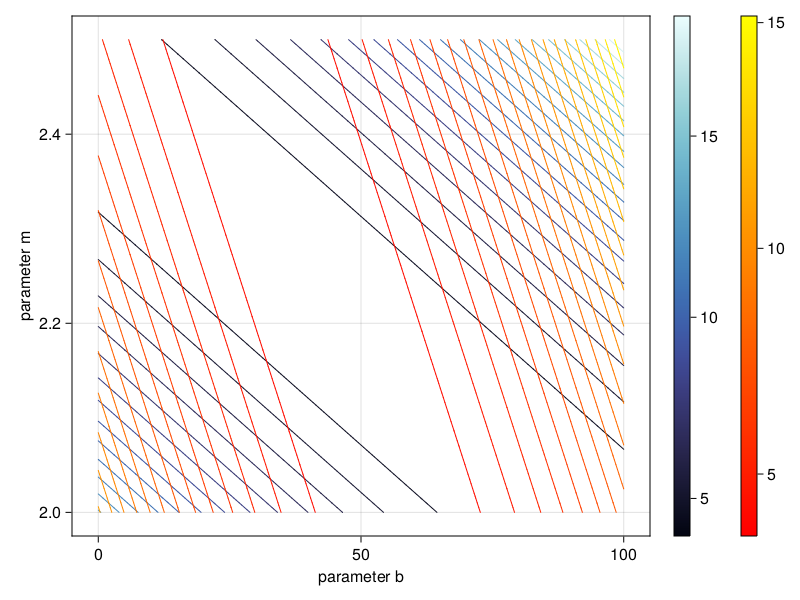

In [108]:
bvals = LinRange(0., 100., 100)
mvals = LinRange(2.0, 2.5, 100);

f = Figure()
Axis(f[1, 1],xlabel = "parameter b", ylabel = "parameter m")
contour1=contour!(bvals, mvals, og1, levels=20, colormap = ColorSchemes.ice.colors )
contour2=contour!(bvals, mvals, og2, levels=20, colormap = ColorSchemes.autumn1.colors)
Colorbar(f[1, 2],contour1)
Colorbar(f[1, 3],contour2)

f

Combine the two data points and make a contour plot. 

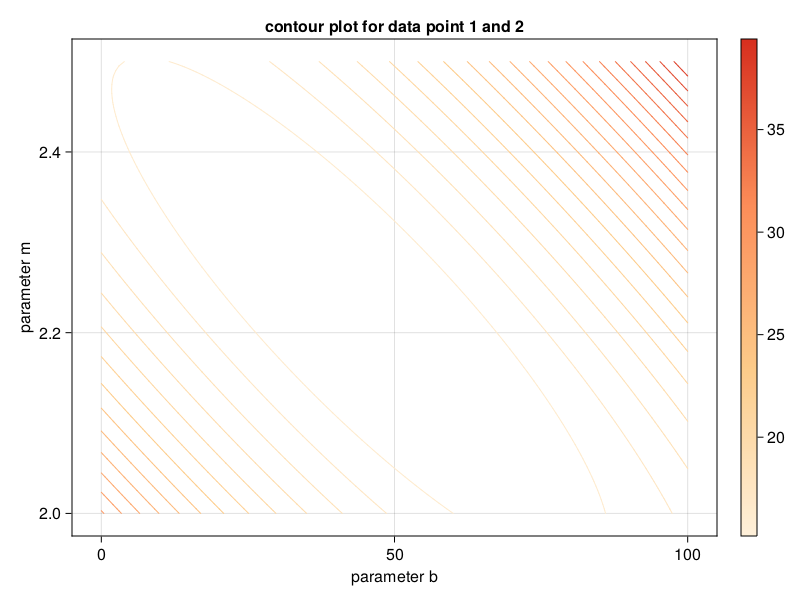

In [109]:
x12= [data.x[1],data.x[2]]
y12= [data.y[1],data.y[2]]
s12= [data.sigma_y[1],data.sigma_y[2]];

bvals = LinRange(0., 100., 100)
mvals = LinRange(2.0, 2.5, 100);

og12 = [objective_gauss([b,m], x12, y12, s12)
      for b in bvals, m in mvals]


f = Figure()
Axis(f[1, 1],xlabel = "parameter b", ylabel = "parameter m", title = "contour plot for data point 1 and 2")
call= contour!(bvals, mvals, og12, levels=20,colormap = ColorSchemes.OrRd_4.colors)
Colorbar(f[1, 2],call)
f
     

Make a contour plot for all data points. 

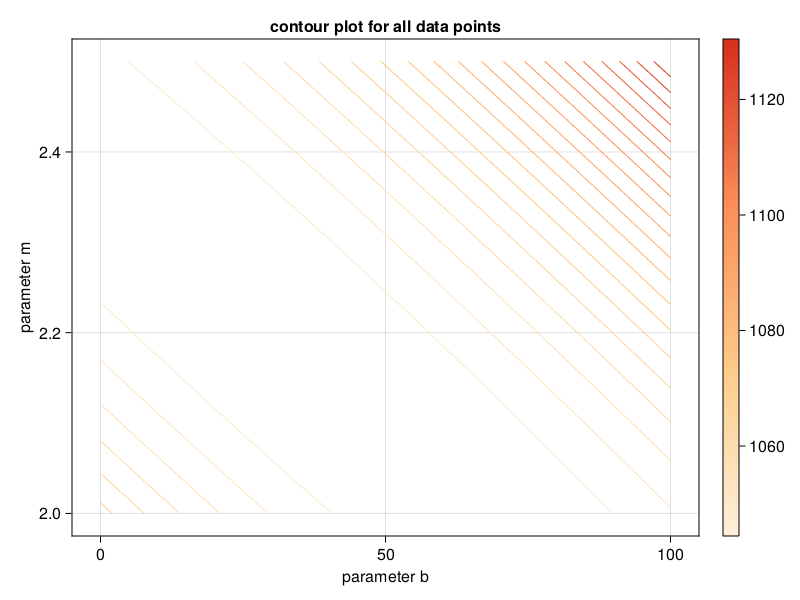

In [110]:
bvals = LinRange(0., 100., 100)
mvals = LinRange(2.0, 2.5, 100);

og12 = [objective_gauss([b,m], data.x, data.y, data.sigma_y)
      for b in bvals, m in mvals]


f = Figure()
Axis(f[1, 1],xlabel = "parameter b", ylabel = "parameter m", title = "contour plot for all data points")
call= contour!(bvals, mvals, og12, levels=20,colormap = ColorSchemes.OrRd_4.colors)
Colorbar(f[1, 2],call)
f

### Next, try plotting the contours for our outlier-rejecting version of the objective function.  Try expanding the range of the m and b parameters and see if you can find the "punk" minimum we found in class.  Are there other minima you can see also?

In [111]:
function objective_outliers(parameters, x, y, sigma)
    b = parameters[1]
    m = parameters[2]

    frac_bad = 0.01
    like_bad = frac_bad * (1. / 600.)

    y_pred = b .+ m .* x
    like_good = (1. - frac_bad) * 1 ./(sqrt(2*π) .* sigma) .* exp.(-0.5 * (y .- y_pred).^2 ./ sigma.^2)
    like = like_bad .+ like_good
    loglike = log.(like)

    return -sum(loglike)
end

objective_outliers (generic function with 1 method)

Setting starting parameters to some speculated values observed by human eyes, and optimize with the outliers objective. 

In [112]:
b_eye = 50
m_eye = 2
# start with guesses observed by eyes
starting_params = [b_eye + 0., m_eye]
result = optimize(p -> objective_outliers(p, data.x, data.y, data.sigma_y),
                  starting_params)
@assert Optim.converged(result)
b_out, m_out = Optim.minimizer(result)

2-element Vector{Float64}:
 34.04506463817255
  2.2400013020506995

Try new starting parameters, we get different optimal values.

In [113]:
starting_params = [700 + 0., -0.5]
result = optimize(p -> objective_outliers(p, data.x, data.y, data.sigma_y),
                  starting_params)
@assert Optim.converged(result)
b_punk, m_punk = Optim.minimizer(result)

2-element Vector{Float64}:
 34.044185215740576
  2.2400060123364565

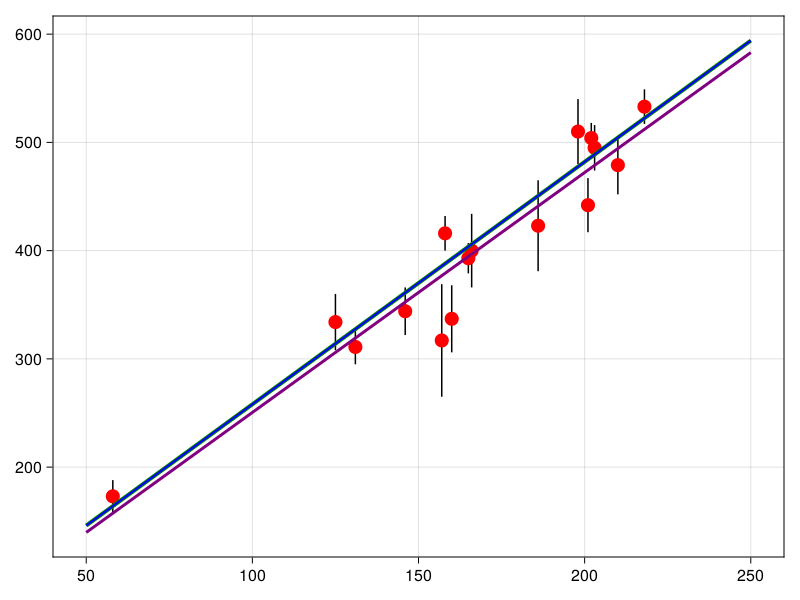

In [116]:
f = Figure()
Axis(f[1, 1])
errorbars!(data.x, data.y, data.sigma_y)
scatter!(data.x, data.y, markersize=20, color=:red)

yy_bad = xx .* m_bad .+ b_bad
lines!(xx, yy_bad, color=:purple, linewidth=3)

yy_out = xx .* m_out .+ b_out
lines!(xx, yy_out, color=:green, linewidth=4)

yy_punk = xx .* m_punk .+ b_punk
lines!(xx, yy_punk, color=:blue, linewidth=2)

f

Contour plot using outliers objective function around the minimum:

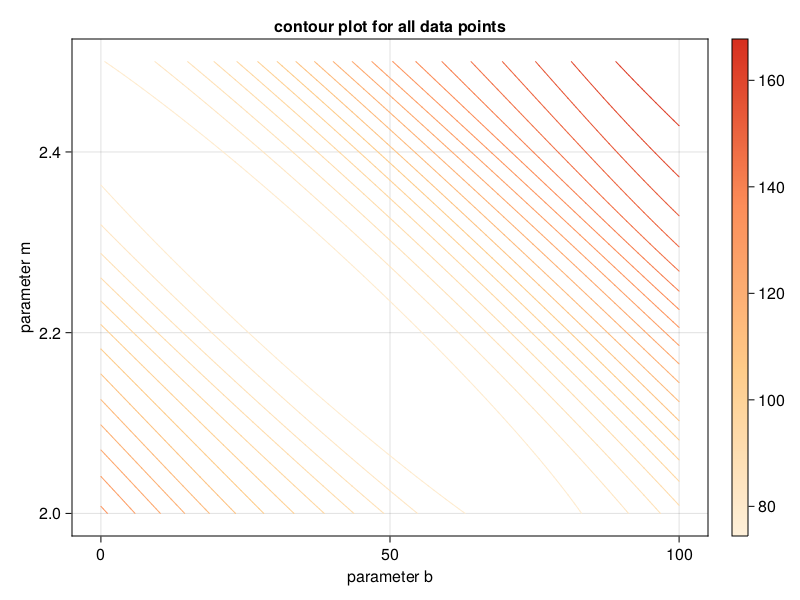

In [117]:
bvals = LinRange(0., 100., 100)
mvals = LinRange(2.0, 2.5, 100);

og12 = [objective_outliers([b,m], data.x, data.y, data.sigma_y)
      for b in bvals, m in mvals]


f = Figure()
Axis(f[1, 1],xlabel = "parameter b", ylabel = "parameter m", title = "contour plot for all data points")
call= contour!(bvals, mvals, og12, levels=20,colormap = ColorSchemes.OrRd_4.colors)
Colorbar(f[1, 2],call)
f

Look at the contour around the punk minimum we found above:

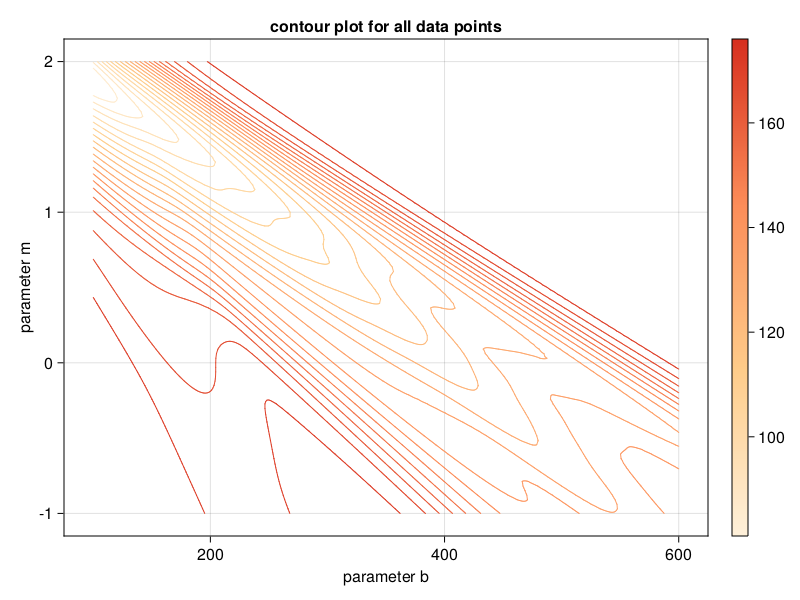

In [120]:
bvals = LinRange(600., 100., 500)
mvals = LinRange(-1.0, 2, 100);

og12 = [objective_outliers([b,m], data.x, data.y, data.sigma_y)
      for b in bvals, m in mvals]


f = Figure()
Axis(f[1, 1],xlabel = "parameter b", ylabel = "parameter m", title = "contour plot for all data points")
call= contour!(bvals, mvals, og12, levels=20,colormap = ColorSchemes.OrRd_4.colors)
Colorbar(f[1, 2],call)
f

# Task 3
Remember that we found that our m,b estimates were anti-correlated. Can you rephrase or reparameterize the equation for a line so that the variables are less correlated?  First, you can try subtracting the average x value from all the x values, and find m',b' for that modified data set.  When you re-run the jack-knife test, does the covariance for the new m',b' values look better?  What happens if you try to convert your m',b' values back to m,b values for the original data set?



First, subtract the average of x from all x values. Find new m and b.

In [121]:
starting_params = [b_eye + 0., m_eye]
average_x = mean(data.x)
result = optimize(p -> objective_gauss(p, data.x .- average_x, data.y, data.sigma_y),
                  starting_params)
@assert Optim.converged(result)
b_new, m_new = Optim.minimizer(result)


2-element Vector{Float64}:
 400.688798813616
   2.2166303100258684

The original jack-knife analysis:

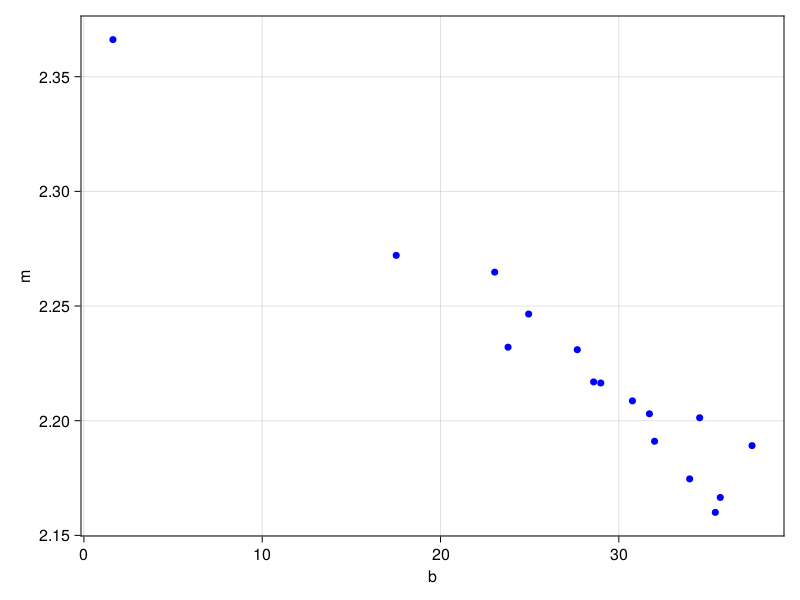

In [126]:
ndata = size(data,1)

B_jack = zeros(ndata)
M_jack = zeros(ndata)

for i in 1:ndata # for each data point, create a copy where we delete that specific point, and do gaussian optimization, append the optimal parameters to the list of B_jack and M_jack
    
    xcopy = copy(data.x)
    deleteat!(xcopy, i)

    ycopy = copy(data.y)
    deleteat!(ycopy, i)

    scopy = copy(data.sigma_y)
    deleteat!(scopy, i)

    starting_params = [b_eye + 0., m_eye]
    result = optimize(p -> objective_gauss(p, xcopy, ycopy, scopy),
                      starting_params)
    @assert Optim.converged(result) # this will return an error if not true
    b_jack, m_jack = Optim.minimizer(result)
    
    B_jack[i] = b_jack
    M_jack[i] = m_jack 
end

f = Figure()
Axis(f[1,1],xlabel = "b", ylabel = "m")
scatter!(B_jack, M_jack, markersize=10, color=:blue) 

f

After reparameterizing m and b:

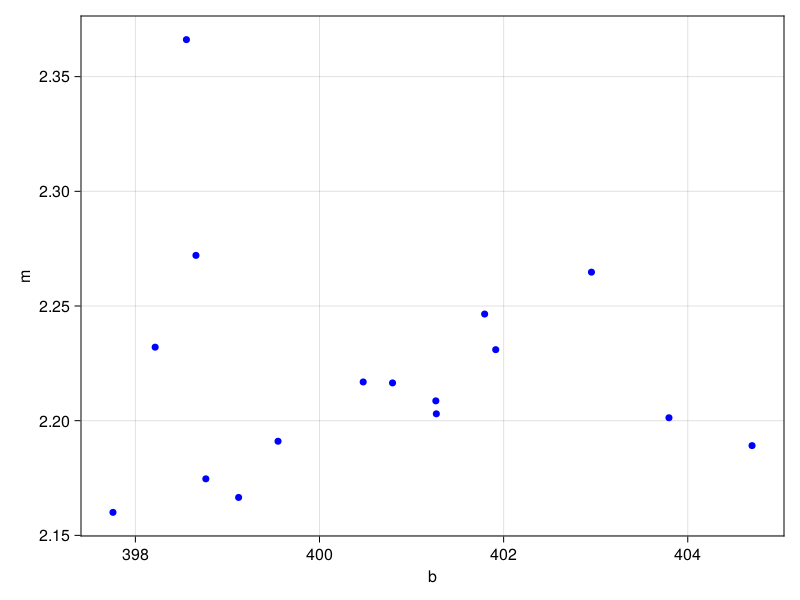

In [130]:
ndata = size(data,1)

B_jack = zeros(ndata)
M_jack = zeros(ndata)

for i in 1:ndata # for each data point, create a copy where we delete that specific point, and do gaussian optimization, append the optimal parameters to the list of B_jack and M_jack
    
    xcopy = copy(data.x .-mean(data.x))
    deleteat!(xcopy, i)

    ycopy = copy(data.y)
    deleteat!(ycopy, i)

    scopy = copy(data.sigma_y)
    deleteat!(scopy, i)

    starting_params = [b_eye + 0., m_eye]
    result = optimize(p -> objective_gauss(p, xcopy, ycopy, scopy),
                      starting_params)
    @assert Optim.converged(result) # this will return an error if not true
    b_jack, m_jack = Optim.minimizer(result)
    
    B_jack[i] = b_jack
    M_jack[i] = m_jack 
end

f = Figure()
Axis(f[1,1],xlabel = "b", ylabel = "m")
scatter!(B_jack, M_jack, markersize=10, color=:blue) 

f

Observe that after reparameterization, b and m do not seem to correlate now. 

# Interview questions

1.  In class, we looked at a likelihood function that had independent Gaussian probability distributions - we assumed that the likelihood for a single data point was a Gaussian (or “normal”) distribution centered on a $y_{pred}$ with known variance $\sigma^2$, and the likelihood for the whole data set was the product of the likelihoods for the individual data points. Now, consider an experiment where we believe the data points will be distributed according to the Poisson distribution.  For example, our model might be that the amount of traffic on a street increases linearly in time (say, during the morning rush hour).  Our observations are counts of how many cars go by during 1-minute periods, so our observations are integers (number of cars during 8:00 to 8:01, number of cars from 8:01 to 8:02, etc), and our $y_{pred}$ value is the “rate”.  The Poisson probability function is $P(k | rate) = rate^k e^{-rate} / k!$, where k is the count (observed number of cars).  Please sketch what the log-likelihood function for this model would look like (that is, please give code, but we don’t care about getting all the punctuation exactly right; pseudo-code is fine).  Discuss why there is no “$y_{error}$” or uncertainty estimate on the counts.

2. We looked at one way of handling outliers in a data set – by using a “mixture model”, where we said that there were two probability distributions the data points could be drawn from – the “good” distribution, where there was a $y_{pred}$ and the data points were drawn from a Gaussian distribution around that $y_{pred}$ – and a “bad” distribution, where the data points could be drawn from the whole range of the y data, with a flat distribution.  And then we had a $p_{good}$ parameter that said what fraction of the data points were drawn from the “good” distribution.  Now, assume that, instead of outliers that are just junk, we have a data set that contains observations from two distinct populations.  (Maybe they’re two different kinds of supernovae, for example.)  And for each data point, we don’t know which population it comes from.  Assume that each population follows a linear model, but with different line parameters (different B and M values).  Please describe a mixture model that will allow you to infer the line parameters for both populations at the same time, and also infer what fraction of the whole data set comes from each population.  Sketch the code for the log-likelihood function.